In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houses_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [73]:
from sklearn import linear_model

houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [74]:
# Data exploration and cleaning.

missing = (houses_df.isnull().sum() / houses_df.isnull().count()).sort_values(ascending = False)
missing.head(10)

# Will simply avoid variables with high amomunts of missing values

poolqc          0.995205
miscfeature     0.963014
alley           0.937671
fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
garageyrblt     0.055479
garagecond      0.055479
garagetype      0.055479
garagefinish    0.055479
dtype: float64

In [75]:
# Get correlation using the numeric features
features_numeric = houses_df.select_dtypes(['int64', 'float64']).columns
features_categorical = houses_df.select_dtypes(['object']).columns

np.abs(houses_df[features_numeric].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending = False)

# Will use 4 results with 60%+ correclation for our numerical features
# overallqual, grlivarea, totalbsmtsf, firstflrsf

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

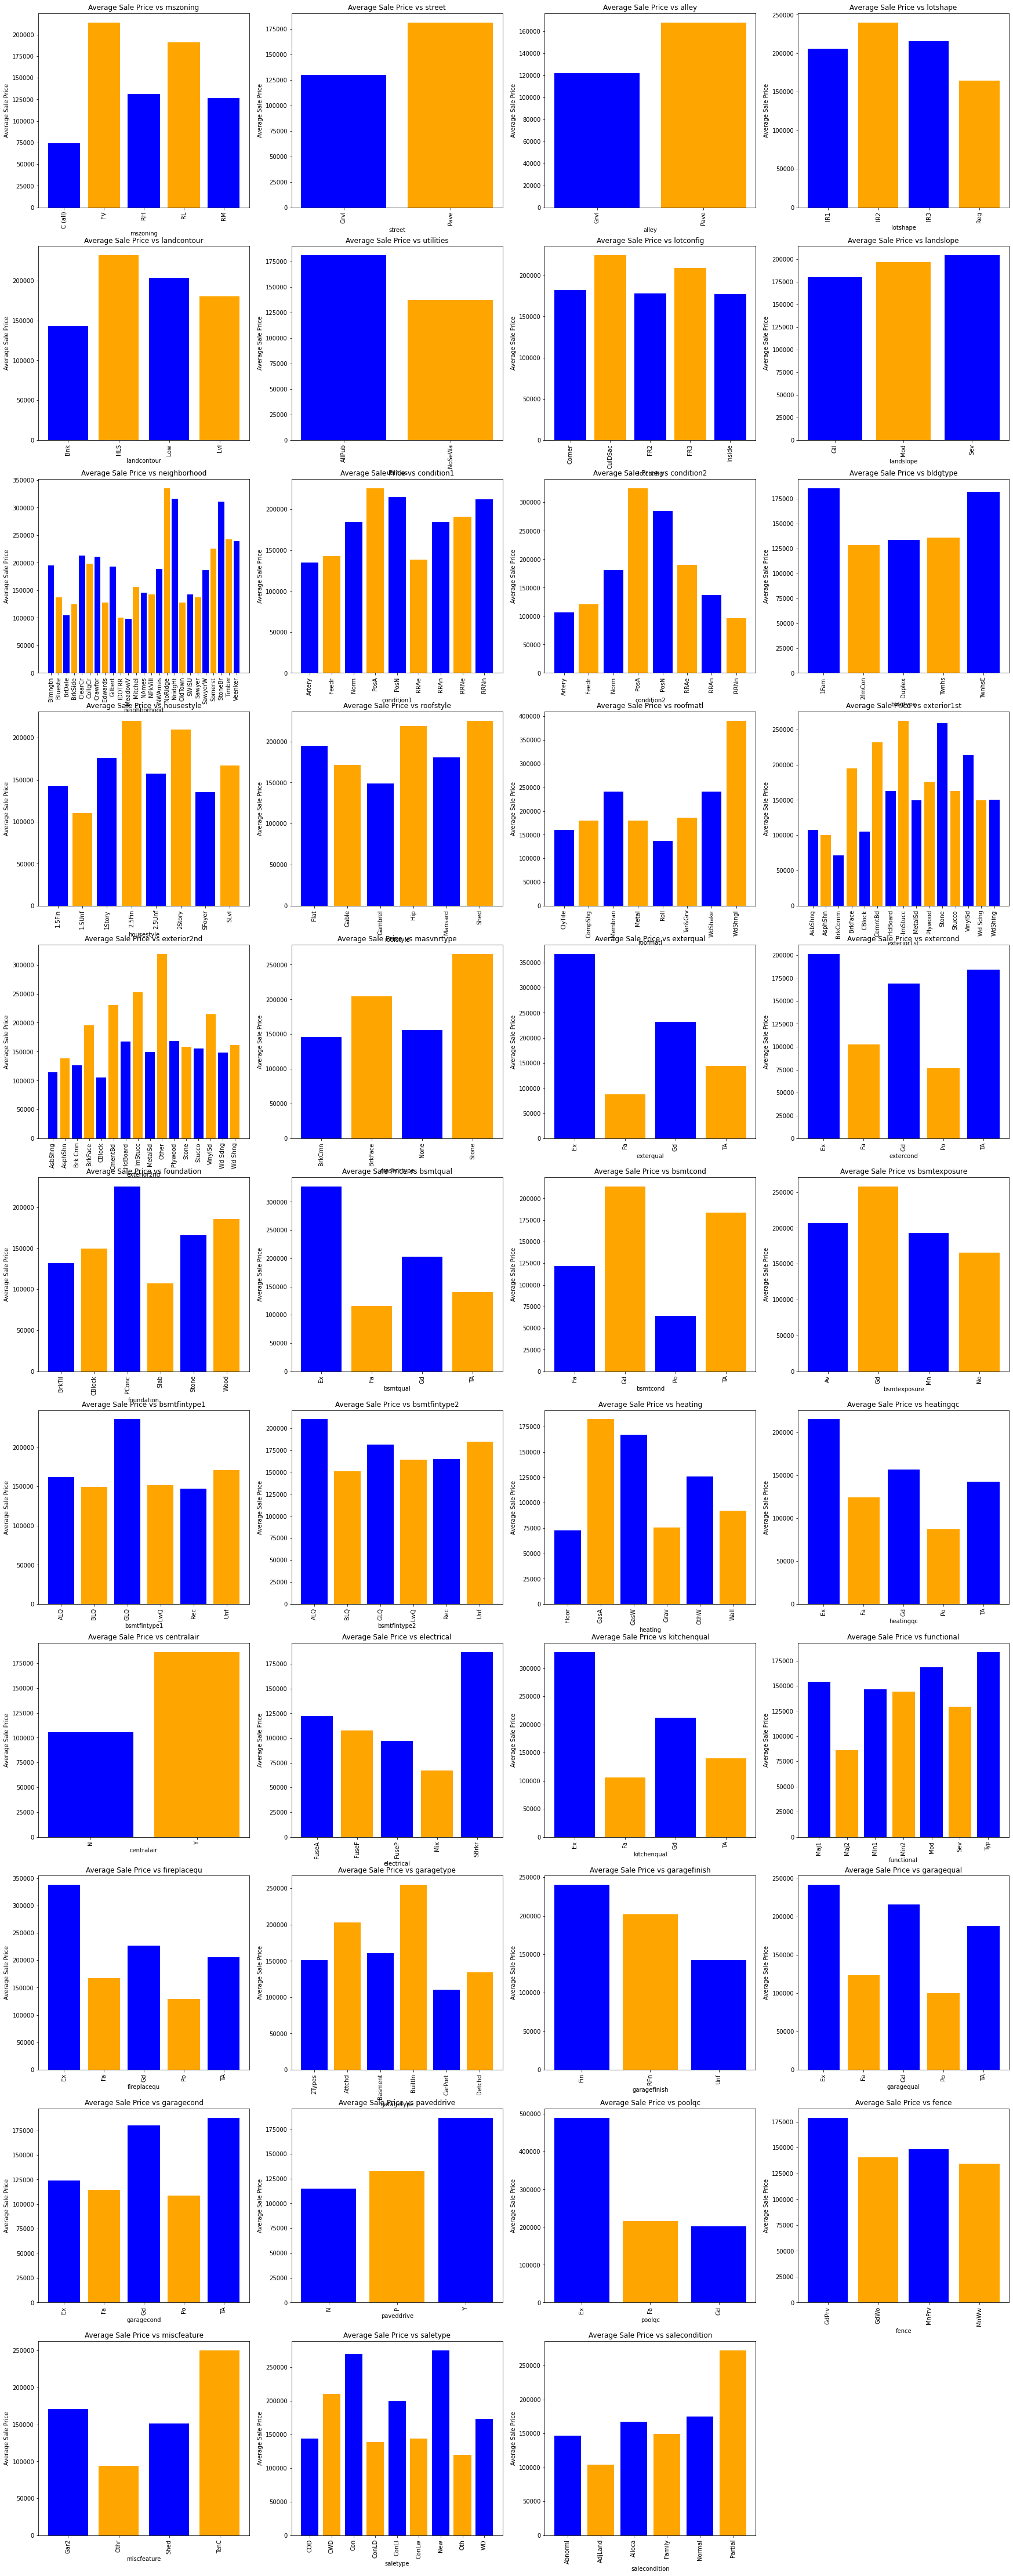

In [76]:
# Use bar charts to identify a non numeric feature for the model

plt.figure(figsize = (30, 80))

for index, column in enumerate(features_categorical):
    plt.subplot(11, 4, index + 1)
    plt.bar(houses_df.groupby(column)["saleprice"].mean().index, houses_df.groupby(column)["saleprice"].mean(), color = ("blue","orange"))
    plt.title("Average Sale Price vs {}".format(column))
    plt.ylabel("Average Sale Price")
    plt.xlabel(column)
    plt.xticks(rotation = 'vertical')

plt.show()

In [77]:
houses_df['centralair'].value_counts()

# There is a noticable sale price difference for central air conditioning

Y    1365
N      95
Name: centralair, dtype: int64

In [78]:
# Selected Features
features_init = houses_df[['overallqual', 'grlivarea', 'totalbsmtsf', 'firstflrsf', 'centralair']]
features_init.head()

centralair_df = pd.get_dummies(features_init['centralair'])
features = features_init.drop(['centralair'], axis = 1).merge(centralair_df, left_index = True, right_index = True)
features.head()

,overallqual,grlivarea,totalbsmtsf,firstflrsf,N,Y
0,7,1710,856,856,0,1
1,6,1262,1262,1262,0,1
2,7,1786,920,920,0,1
3,7,1717,756,961,0,1
4,8,2198,1145,1145,0,1


In [82]:
# OLS and Model

import statsmodels.regression.linear_model as smf
import statsmodels.tools.tools as sm_tools

X = features
Y = houses_df.saleprice
X = sm_tools.add_constant(X)
results = smf.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     855.3
Date:                Fri, 28 Mar 2025   Prob (F-statistic):               0.00
Time:                        22:27:17   Log-Likelihood:                -17543.
No. Observations:                1460   AIC:                         3.510e+04
Df Residuals:                    1454   BIC:                         3.513e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.433e+04   3377.803    -22.006      0.000    -8.1e+04   -6.77e+04
overallqual  2.762e+04   1048.864     26.335      0.000    2.56e+04    2.97e+04
grlivarea      46.9016      2.760     16.990      0.000      41.487      52.317
totalbsmtsf    24.5082      4.447      5.511      0.000      15.785      33.232
firstflrsf     17.0189      5.160      3.299      0.001       6.898      27.140
N            -4.54e+04   2972.115    -15.275      0.000   -5.12e+04   -3.96e+04
Y           -2.893e+04   2609.431    -11.088      0.000   -3.41e+04   -2.38e+04
==============================================================================
Omnibus:                      491.366   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43573.793
Skew:                          -0.594   Prob(JB):                         0.00
Kurtosis:                      29.737   Cond. No.                     3.82e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.22e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""